In [ ]:
!pip install graphviz==0.10
!apt-get install graphviz

  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
uri = "dadosParaMineracaoRegrasAssociacao2019.csv"
dados = pd.read_csv(uri,sep=";",encoding='latin1')
dados['TP_LINGUA'].replace(0, "Inglês", inplace=True)
dados['TP_LINGUA'].replace(1, "Espanhol", inplace=True)
dados.rename(columns={"Q024" : "Tem Computador"}, inplace=True)
dados.rename(columns={"Q022" : "Tem Celular"}, inplace=True)
dados.rename(columns={"Q025" : "Tem Internet"}, inplace=True)
dados.rename(columns={"Q001" : "Estudo Pai"}, inplace=True)
dados.rename(columns={"Q002" : "Estudo Mãe"}, inplace=True)
dados.rename(columns={"Q003" : "Trabalho Pai"}, inplace=True)
dados.rename(columns={"Q004" : "Trabalho Mãe"}, inplace=True)
dados.head()

,TP_SEXO,TP_COR_RACA,CO_ESCOLA,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,NU_NOTA_REDACAO,CO_UF_ESC,Estudo Pai,Estudo Mãe,Trabalho Pai,Trabalho Mãe,Tem Celular,Tem Computador,Tem Internet,RendaMaxima,ClasseSocial,anosEstudoPai,anosEstudoMae,COR_RACA,RazaoPessoasQuarto,PessoasPorQuarto,NU_MEDIA,MEDIA_FAIXA
0,F,Branco,15230023.0,Paragominas,PA,Particular,Urbano,574.2,538.7,582.6,571.5,Inglês,640.0,15.0,NaoSabe,Medio,"Grupo(A,B,C)","Grupo(D,E)",Sim,Sim,Sim,1497,E,0,12,Branco,0.75,"(0, 1]",581.40,"(576.04, 713.43]"
1,F,Parda,15042626.0,Belém,PA,Estadual,Urbano,369.7,398.2,395.6,473.8,Inglês,480.0,15.0,FundamentalIncompleto,FundamentalIncompleto,"Grupo(A,B,C)","Grupo(A,B,C)",Sim,Não,Nao,998,E,4,4,NaoBranco,4.00,"(3, 4]",423.46,"(0.0, 438.65]"
2,F,Parda,15045560.0,Castanhal,PA,Estadual,Urbano,376.4,354.7,525.8,389.4,Espanhol,660.0,15.0,FundamentalIncompleto,FundamentalCompleto,"Grupo(A,B,C)","Grupo(A,B,C)",Sim,Não,Nao,1497,E,4,9,NaoBranco,1.50,"(1, 2]",461.26,"(438.65, 576.04]"
3,F,Parda,15038378.0,Belém,PA,Estadual,Urbano,423.0,372.8,488.7,516.5,Inglês,540.0,15.0,Medio,Medio,"Grupo(A,B,C)","Grupo(A,B,C)",Sim,Não,Nao,1497,E,12,12,NaoBranco,3.00,"(2, 3]",468.20,"(438.65, 576.04]"
4,F,Parda,15582949.0,Paragominas,PA,Estadual,Urbano,412.5,417.2,485.1,446.2,Espanhol,580.0,15.0,Medio,Medio,"Grupo(A,B,C)","Grupo(A,B,C)",Sim,Não,Sim,1497,E,12,12,NaoBranco,1.50,"(1, 2]",468.20,"(438.65, 576.04]"


In [ ]:
dados['TP_COR_RACA'].value_counts()

Parda           414812
Branco          358160
Preta           103088
Amarelo          20581
NaoDeclarado     18628
Indigena          5319
Name: TP_COR_RACA, dtype: int64

# Teste de Contingência com Chi2



In [ ]:

# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2 as chi2_sypy

def create_contingency_table(dataframe, feature1,feature2):
  table = pd.crosstab(dataframe[feature1], dataframe[feature2], margins = False) 
  return table


def calc_contingency(table):
  print(table)
  stat, p, dof, expected = chi2_contingency(table)
  print('dof=%d' % dof)
  print(expected)
  # interpret test-statistic
  prob = 0.95
  critical = chi2_sypy.ppf(prob, dof)
  print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
  if abs(stat) >= critical:
    print('Dependent (reject H0)')
  else:
    print('Independent (fail to reject H0)')
  # interpret p-value
  alpha = 1.0 - prob
  print('significance=%.3f, p=%.3f' % (alpha, p))
  if p <= alpha:
    print('Dependent (reject H0)')
  else:
    print('Independent (fail to reject H0)')

In [ ]:
calc_contingency(create_contingency_table(dados,'COR_RACA','TP_LINGUA'))


TP_LINGUA     Espanhol  Inglês
COR_RACA                      
Branco          129812  228348
NaoBranco       286615  257185
NaoDeclarado      8961    9667
dof=2
[[165499.62206764 192660.37793236]
 [251280.69711967 292519.30288033]
 [  8607.6808127   10020.3191873 ]]
probability=0.950, critical=5.991, stat=23569.852
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)





# Classificação Binária


## Qual classificação vamos usar?

* Terceiro Quartil (Adeodato 2019) https://sci-hub.se/https://ieeexplore.ieee.org/abstract/document/8923965
* 600 (Franco 2020) https://sol.sbc.org.br/index.php/sbie/article/view/12867
<!-- * KMeans Clustering (Silva, 2020) https://sol.sbc.org.br/index.php/sbie/article/view/12763 -->

In [ ]:
classificacao = dados.NU_MEDIA > dados.NU_MEDIA.quantile(0.75)
#classificacao = dados.NU_MEDIA > 600

dados['classificacao'] = classificacao

# dados['classificacao'].replace(False, "Baixo Desempenho", inplace=True)
# dados['classificacao'].replace(True, "Alto Desempenho", inplace=True)
dados['classificacao'].replace(False, 0, inplace=True)
dados['classificacao'].replace(True, 1, inplace=True)


In [ ]:
dados.NU_MEDIA.quantile(0.75)

580.64

### Feature Selection

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
# feature selection
def select_features(treino_x, treino_y, teste_x, func_score = chi2, num_features='all'):
	fs = SelectKBest(score_func=func_score, k=num_features)
	fs.fit(treino_x, treino_y)
	X_train_fs = fs.transform(treino_x)
	X_test_fs = fs.transform(teste_x)
	return X_train_fs, X_test_fs, fs

def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

def plot_score_features(features_selecionadas_plotagem, dataframe, ylabel = "Score"):
  grafico = dataframe.plot.bar()
  grafico.figure.set_figwidth(10)
  grafico.figure.set_figheight(10)
  grafico.set_ylim(0,80000)
  xticklabels = grafico.axes.set_xticklabels(features_selecionadas_plotagem,rotation=-45)
  ylabel = grafico.set_ylabel(ylabel)


In [ ]:
x = dados[['TP_SEXO',
 'TP_COR_RACA',
 'SG_UF_ESC',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_LOCALIZACAO_ESC',
 'TP_LINGUA',
 'Estudo Pai',
 'Estudo Mãe',
 'Trabalho Pai',
 'Trabalho Mãe',
 'Tem Celular',
 'Tem Computador',
 'Tem Internet',
 'ClasseSocial']]
x = x.astype(str)
y = dados["classificacao"]
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,stratify = y, random_state=SEED)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

# # prepare input data
treino_x_enc, teste_x_enc = prepare_inputs(treino_x, teste_x)
# prepare output data
treino_y_enc, teste_y_enc = prepare_targets(treino_y, teste_y)

X_train_fs, X_test_fs, fs = select_features(treino_x_enc, treino_y_enc, teste_x_enc,chi2, 5)
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
result_selection = pd.DataFrame(fs.scores_,[i for i in range(len(fs.scores_))])
dict_qtd = {0:"Features"}
result_selection.rename(columns = dict_qtd , inplace = True)
x.iloc[:,[i for i in range(len(result_selection))]].columns.tolist()



Treinaremos com 690441 elementos e testaremos com 230147 elementos
Feature 0: 2379.446625
Feature 1: 24540.577908
Feature 2: 17390.909874
Feature 3: 326332.672421
Feature 4: 37.527613
Feature 5: 17872.775851
Feature 6: 39578.771346
Feature 7: 53228.402659
Feature 8: 15367.372279
Feature 9: 22708.941672
Feature 10: 37.968189
Feature 11: 29468.097290
Feature 12: 6005.566415
Feature 13: 30622.491036


['TP_SEXO',
 'TP_COR_RACA',
 'SG_UF_ESC',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_LOCALIZACAO_ESC',
 'TP_LINGUA',
 'Estudo Pai',
 'Estudo Mãe',
 'Trabalho Pai',
 'Trabalho Mãe',
 'Tem Celular',
 'Tem Computador',
 'Tem Internet',
 'ClasseSocial']

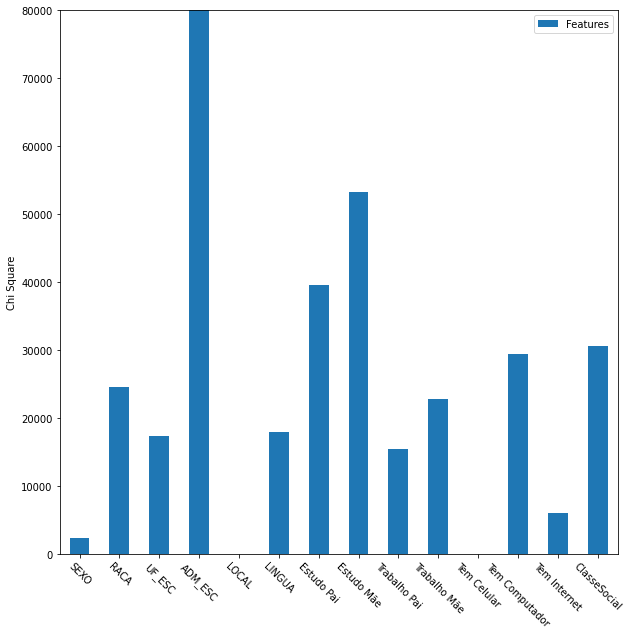

In [ ]:
 features_selecionadas_plotagem =   ['SEXO',
 'RACA',
 'UF_ESC',
 'ADM_ESC',
 'LOCAL',
 'LINGUA',
 'Estudo Pai',
 'Estudo Mãe',
 'Trabalho Pai',
 'Trabalho Mãe',
 'Tem Celular',
 'Tem Computador',
 'Tem Internet',
 'ClasseSocial']
plot_score_features(features_selecionadas_plotagem,result_selection,'Chi Square')


In [ ]:
scores = {}
for i in range(len(result_selection)):
#     print(x.iloc[:,[i]].columns.tolist()[0])
    scores[x.iloc[:,[i]].columns.tolist()[0]] = result_selection.iloc[i].values[0]
print(scores)

oredenados = sorted(scores.items(), key=lambda item: item[1], reverse = True)

nomes = []
for result in (oredenados[:5]):
    nomes.append(result[0])
    print(result[0])
    
print(nomes)

In [ ]:
x = dados[nomes]
x = x.astype(str)
one_hot_data = pd.get_dummies(x)
x = one_hot_data

y = dados["classificacao"]
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,stratify = y, random_state=SEED)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

In [ ]:
modelo = DecisionTreeClassifier(max_depth=5)
modelo = modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)
 
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_x,modelo)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, previsoes,labels), figsize=(15,15), categories=labels)

In [ ]:
r = export_text(modelo,x.columns.tolist())
print(r)

|--- TP_DEPENDENCIA_ADM_ESC_Estadual <= 0.50
|   |--- ClasseSocial_E <= 0.50
|   |   |--- ClasseSocial_D <= 0.50
|   |   |   |--- ClasseSocial_C <= 0.50
|   |   |   |   |--- ClasseSocial_A <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- ClasseSocial_A >  0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- ClasseSocial_C >  0.50
|   |   |   |   |--- TP_DEPENDENCIA_ADM_ESC_Municipal <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- TP_DEPENDENCIA_ADM_ESC_Municipal >  0.50
|   |   |   |   |   |--- class: 0.0
|   |   |--- ClasseSocial_D >  0.50
|   |   |   |--- TP_DEPENDENCIA_ADM_ESC_Municipal <= 0.50
|   |   |   |   |--- Tem Internet_Nao <= 0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- Tem Internet_Nao >  0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- TP_DEPENDENCIA_ADM_ESC_Municipal >  0.50
|   |   |   |   |--- Tem Internet_Nao <= 0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Tem Internet_Nao >  0.50
|   |  

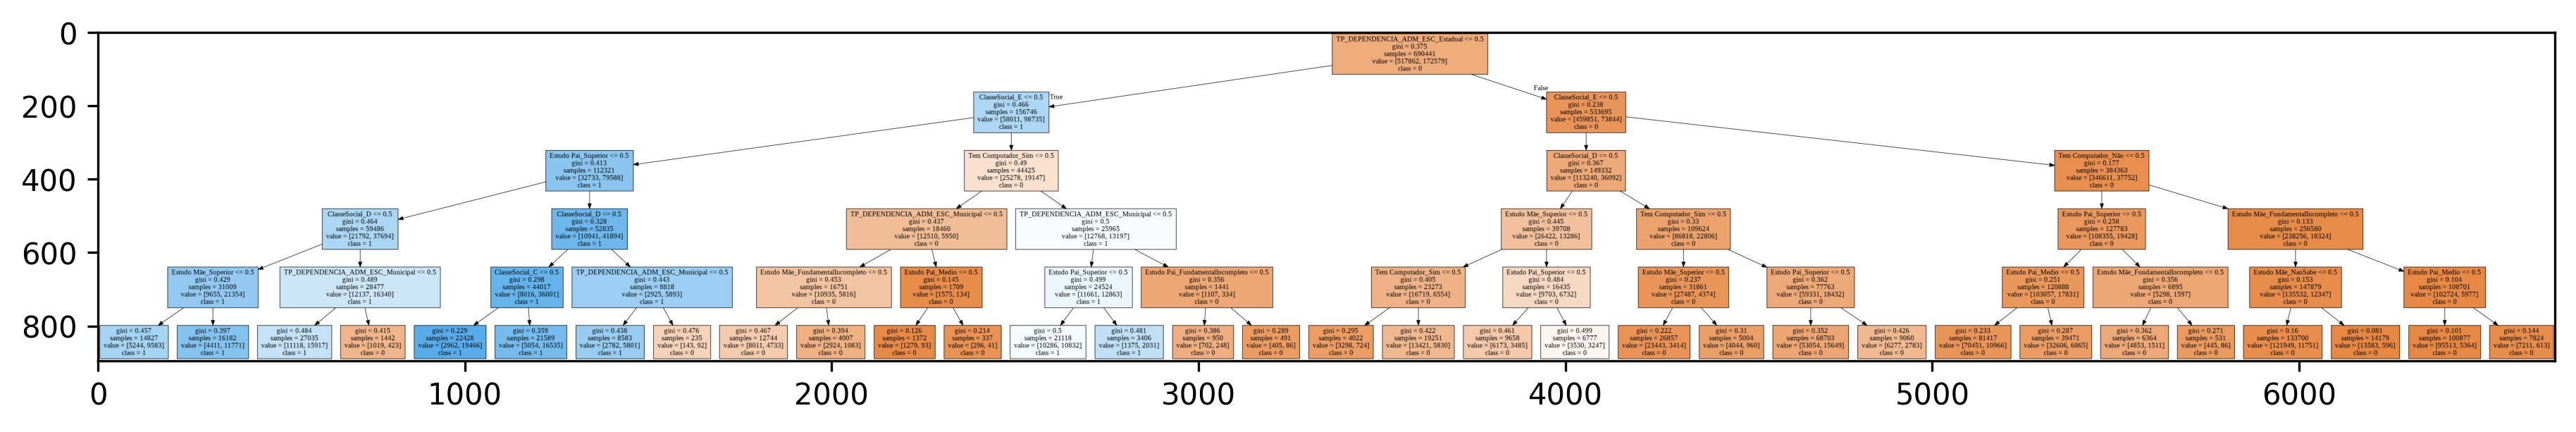

In [ ]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,15), dpi=300)
!pip install pydotplus
import pydotplus


graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')    
plt.imshow(plt.imread('tree.png'))

In [ ]:
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = x.columns.tolist())
grafico = graphviz.Source(dot_data)
grafico.save("tree.png")

'tree.png'

In [ ]:
features_selecionadas = ['TP_SEXO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_LINGUA',
       'Estudo Pai', 'Estudo Mãe',
       'Tem Celular', 'Tem Computador',
       'Tem Internet','ClasseSocial',
       'COR_RACA','SG_UF_ESC','PessoasPorQuarto'
    ]
y = dados["classificacao"]
x = dados[features_selecionadas]  
x = x.astype(str)
# one_hot_data = pd.get_dummies(x)
# x = one_hot_data

In [ ]:
x

,TP_SEXO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_LINGUA,Estudo Pai,Estudo Mãe,Tem Celular,Tem Computador,Tem Internet,ClasseSocial,COR_RACA,SG_UF_ESC,PessoasPorQuarto
0,F,Particular,Urbano,Inglês,NaoSabe,Medio,Sim,Sim,Sim,E,Branco,PA,"(0, 1]"
1,F,Estadual,Urbano,Inglês,FundamentalIncompleto,FundamentalIncompleto,Sim,Não,Nao,E,NaoBranco,PA,"(3, 4]"
2,F,Estadual,Urbano,Espanhol,FundamentalIncompleto,FundamentalCompleto,Sim,Não,Nao,E,NaoBranco,PA,"(1, 2]"
3,F,Estadual,Urbano,Inglês,Medio,Medio,Sim,Não,Nao,E,NaoBranco,PA,"(2, 3]"
4,F,Estadual,Urbano,Espanhol,Medio,Medio,Sim,Não,Sim,E,NaoBranco,PA,"(1, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
920583,F,Estadual,Urbano,Inglês,FundamentalCompleto,Medio,Sim,Sim,Sim,E,Branco,MG,"(2, 3]"
920584,F,Estadual,Urbano,Inglês,Superior,Superior,Sim,Sim,Sim,C,Branco,MG,"(1, 2]"
920585,F,Federal,Urbano,Inglês,Superior,Superior,Sim,Sim,Sim,C,NaoBranco,MG,"(1, 2]"
920586,F,Federal,Urbano,Espanhol,Medio,Superior,Sim,Sim,Sim,C,NaoBranco,MG,"(1, 2]"


In [ ]:
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 690441 elementos e testaremos com 230147 elementos


In [ ]:
# prepare input data
treino_x_enc, teste_x_enc = prepare_inputs(treino_x, teste_x)
# prepare output data
treino_y_enc, teste_y_enc = prepare_targets(treino_y, teste_y)

In [ ]:
X_train_fs, X_test_fs, fs = select_features(treino_x_enc, treino_y_enc, teste_x_enc, chi2)
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
result_selection = pd.DataFrame(fs.scores_,[i for i in range(len(fs.scores_))])
dict_qtd = {0:"Features"}
result_selection.rename(columns = dict_qtd , inplace = True)

Feature 0: 0.021202
Feature 1: 0.111773
Feature 2: 0.099091
Feature 3: 0.056228
Feature 4: 0.080693
Feature 5: 0.081385
Feature 6: 0.101596
Feature 7: 0.074174
Feature 8: 0.085771
Feature 9: 0.147718
Feature 10: 0.063355
Feature 11: 0.019226
Feature 12: 0.057776


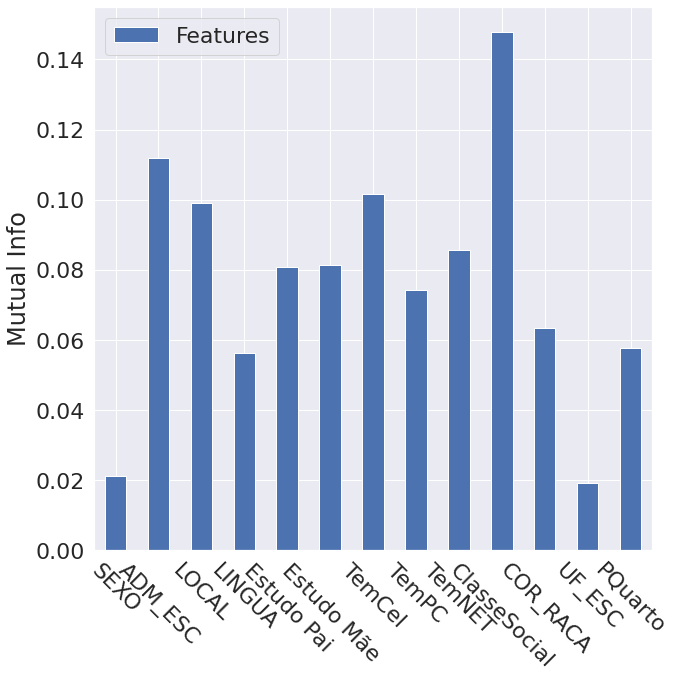

Feature 0: 2379.446625
Feature 1: 326332.672421
Feature 2: 37.527613
Feature 3: 17872.775851
Feature 4: 39578.771346
Feature 5: 53228.402659
Feature 6: 37.968189
Feature 7: 29468.097290
Feature 8: 6005.566415
Feature 9: 30622.491036
Feature 10: 11082.513588
Feature 11: 17390.909874
Feature 12: 14352.832008


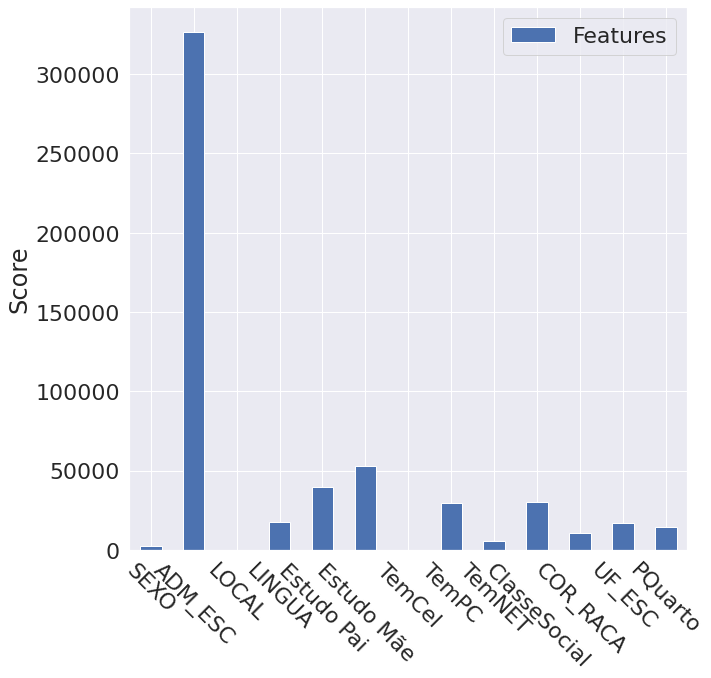

In [ ]:
X_train_fs, X_test_fs, fs = select_features(treino_x_enc, treino_y_enc, teste_x_enc,chi2,4)
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
result_selection = pd.DataFrame(fs.scores_,[i for i in range(len(fs.scores_))])
dict_qtd = {0:"Features"}
result_selection.rename(columns = dict_qtd , inplace = True)
features_selecionadas_plotagem = ['SEXO',
 'ADM_ESC',
 'LOCAL',
 'LINGUA',
 'Estudo Pai',
 'Estudo Mãe',
 'TemCel',
 'TemPC',
 'TemNET',
 'ClasseSocial',
 'COR_RACA',
 'UF_ESC',
 'PQuarto']
plot_score_features(features_selecionadas_plotagem,result_selection)


In [ ]:
y.value_counts()

0.0    690482
1.0    230106
Name: classificacao, dtype: int64

A acurácia foi 82.03%
0.811184753217501


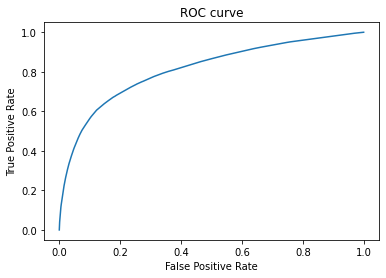

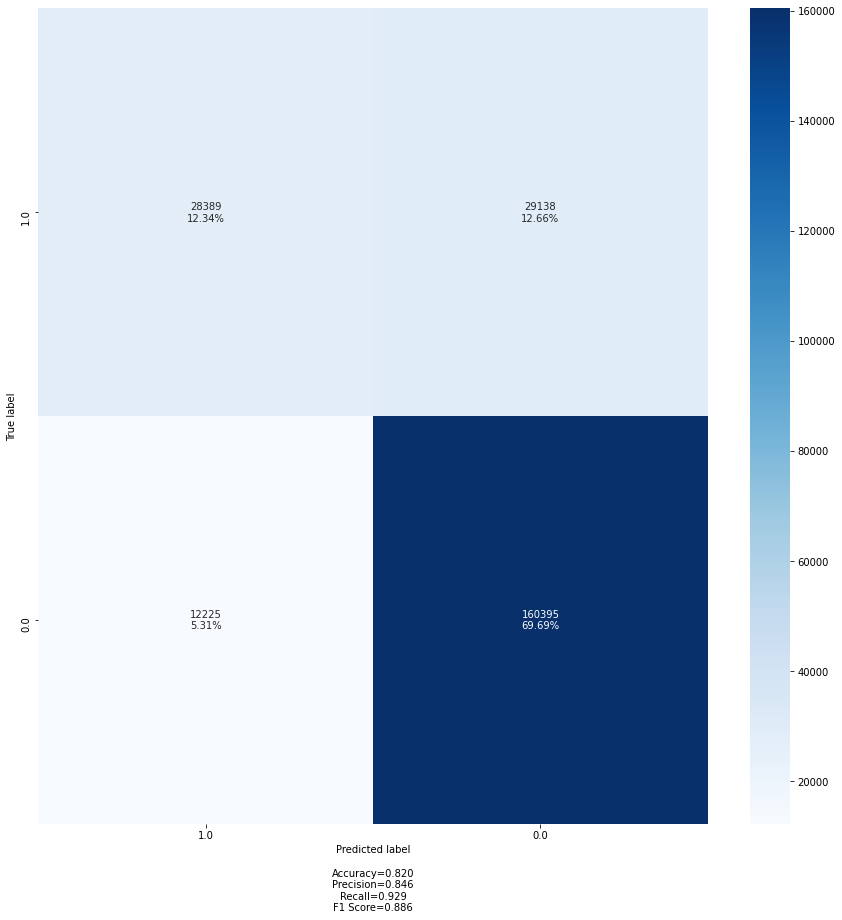

In [ ]:
X_train_fs, X_test_fs, fs = select_features(treino_x_enc, treino_y_enc, teste_x_enc,chi2, 4)
modelo = DecisionTreeClassifier(max_depth=10)
modelo = modelo.fit(X_train_fs, treino_y_enc)
previsoes = modelo.predict(X_test_fs)

acuracia = accuracy_score(teste_y_enc, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y_enc,X_test_fs,modelo)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y_enc, previsoes,labels), figsize=(15,15), categories=labels)





Resultado da classificação 82.38%


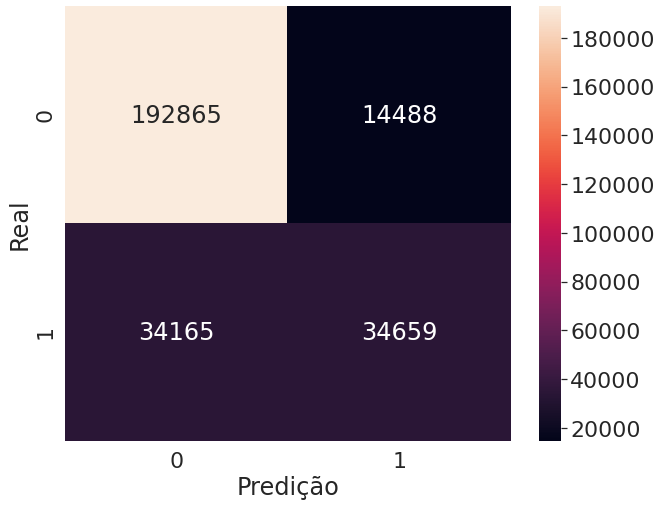

In [ ]:
from sklearn.feature_selection import RFE
from numpy import random

SEED= 1234
random.seed(SEED)

features_selecionadas = ['TP_SEXO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_LINGUA',
       'Estudo Pai', 'Estudo Mãe',
       'Tem Celular', 'Tem Computador',
       'Tem Internet','ClasseSocial',
       'COR_RACA','SG_UF_ESC','PessoasPorQuarto'
    ]
y = dados["classificacao"]
x = dados[features_selecionadas]  
x = x.astype(str)
one_hot_data = pd.get_dummies(x)
x = one_hot_data

treino_x, teste_x, treino_y, teste_y = train_test_split(x, 
                                                        y,
                                                        test_size = 0.3)

classificador = DecisionTreeClassifier(random_state=1234)
classificador.fit(treino_x, treino_y)
selecionador_rfe = RFE(estimator = classificador, n_features_to_select = 5, step = 1)
selecionador_rfe.fit(treino_x, treino_y)
treino_rfe = selecionador_rfe.transform(treino_x)
teste_rfe = selecionador_rfe.transform(teste_x)
classificador.fit(treino_rfe, treino_y)

matriz_confusao = confusion_matrix(teste_y,classificador.predict(teste_rfe))
plt.figure(figsize = (10, 8))
sns.set(font_scale= 2)
sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel= "Real")

print("Resultado da classificação %.2f%%" %(classificador.score(teste_rfe,teste_y)*100))

A acurácia foi 82.38%
0.8194987507339844


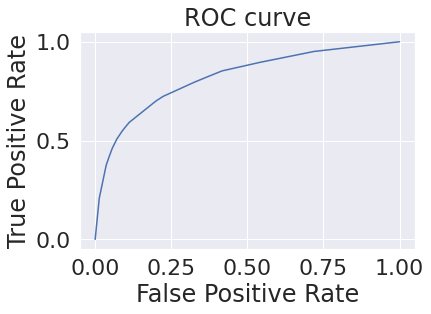

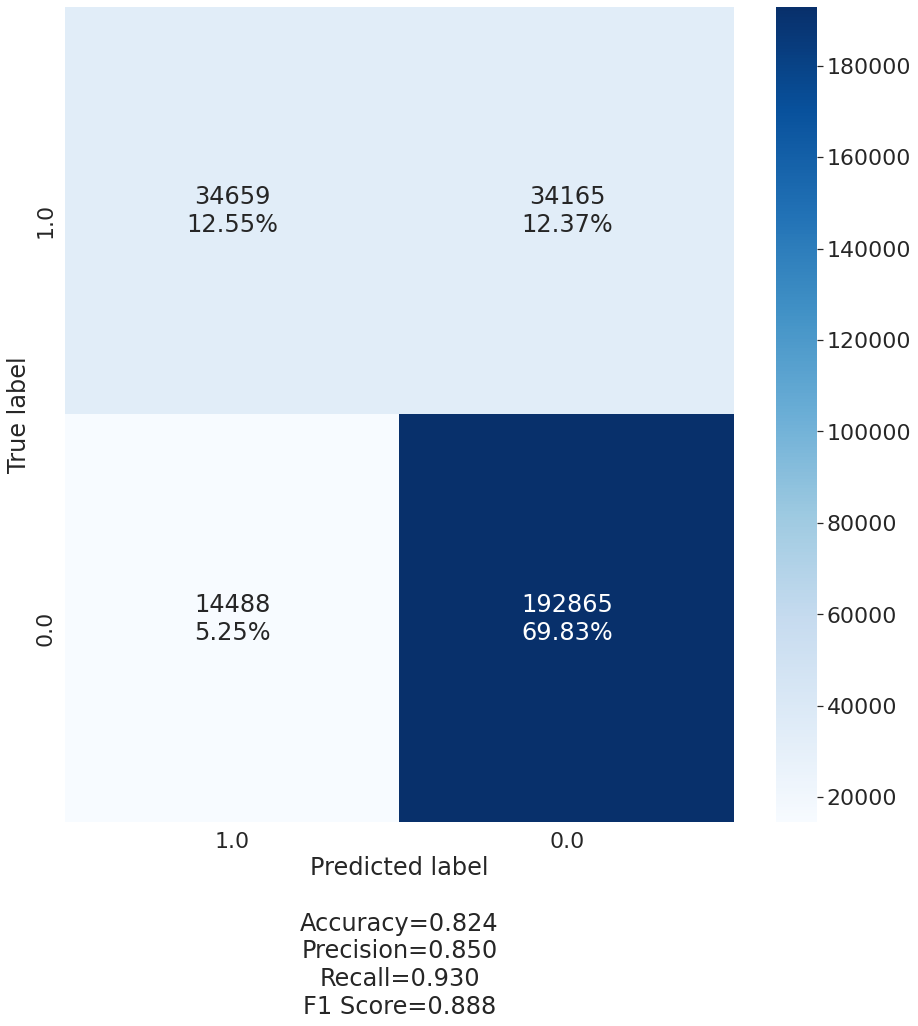

In [ ]:
acuracia = accuracy_score(teste_y, classificador.predict(teste_rfe)) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_rfe,classificador)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, classificador.predict(teste_rfe),labels), figsize=(15,15), categories=labels)

In [ ]:
best_features = [features_selecionadas[1],features_selecionadas[3],features_selecionadas[4],features_selecionadas[5],
                 features_selecionadas[7],features_selecionadas[9],features_selecionadas[11],features_selecionadas[12]]

In [ ]:
# x = dados[["Q002", "RendaMaxima","TP_DEPENDENCIA_ADM_ESC","Q024","TP_COR_RACA", "TP_SEXO"]]
x = dados[best_features]

y = dados["classificacao"]

In [ ]:
one_hot_data = pd.get_dummies(x)
x = one_hot_data

# y=y.astype('string')

In [ ]:
# x.drop("classificacao",inplace=True,axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920588 entries, 0 to 920587
Data columns (total 55 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   TP_DEPENDENCIA_ADM_ESC_Estadual    920588 non-null  uint8
 1   TP_DEPENDENCIA_ADM_ESC_Federal     920588 non-null  uint8
 2   TP_DEPENDENCIA_ADM_ESC_Municipal   920588 non-null  uint8
 3   TP_DEPENDENCIA_ADM_ESC_Particular  920588 non-null  uint8
 4   TP_LINGUA_Espanhol                 920588 non-null  uint8
 5   TP_LINGUA_Inglês                   920588 non-null  uint8
 6   Estudo Pai_FundamentalCompleto     920588 non-null  uint8
 7   Estudo Pai_FundamentalIncompleto   920588 non-null  uint8
 8   Estudo Pai_Medio                   920588 non-null  uint8
 9   Estudo Pai_NaoSabe                 920588 non-null  uint8
 10  Estudo Pai_Superior                920588 non-null  uint8
 11  Estudo Mãe_FundamentalCompleto     920588 non-null  uint8
 12  Es

In [ ]:
y.value_counts(normalize=True)

0.0    0.750045
1.0    0.249955
Name: classificacao, dtype: float64

## Treino e Teste

In [ ]:
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25,stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 690441 elementos e testaremos com 230147 elementos


## Baseline

A acurácia foi 50.14%
0.5


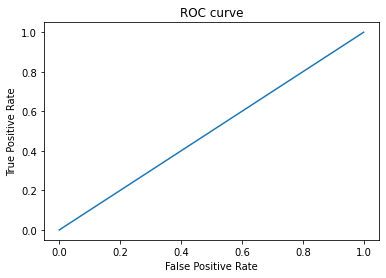

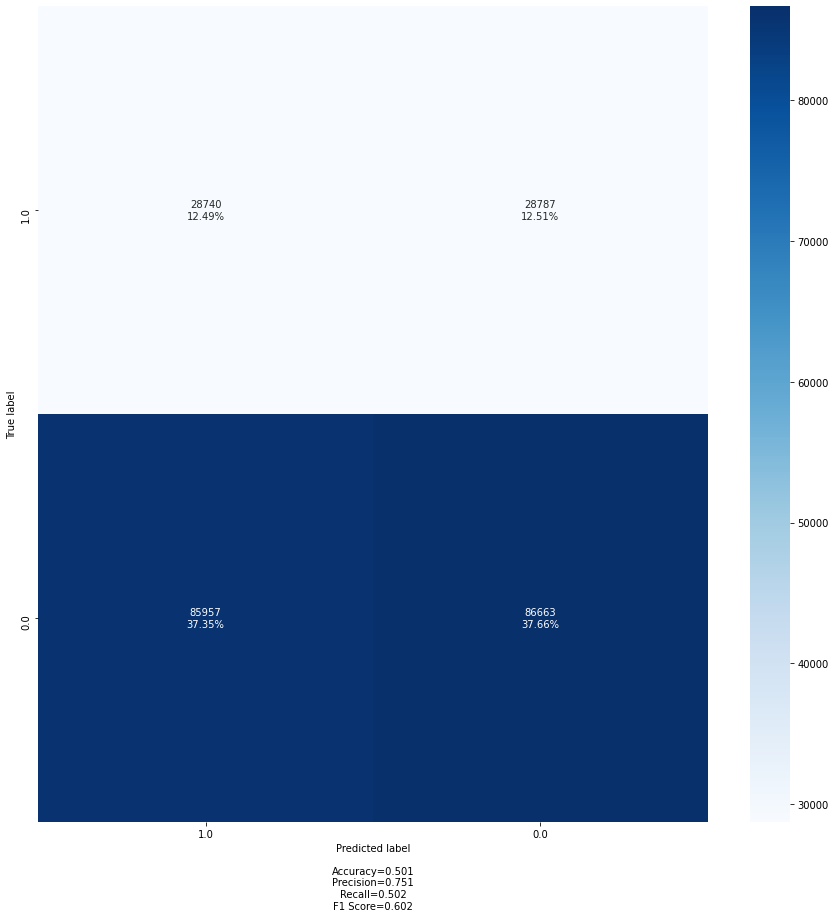

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform") #uniform
dummy_clf.fit(treino_x, treino_y)
 
previsoes_burras = dummy_clf.predict(teste_x)
 
acuracia = accuracy_score(teste_y, previsoes_burras) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_x,dummy_clf)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, previsoes_burras,labels), figsize=(15,15), categories=labels)

A acurácia foi 75.00%
0.5


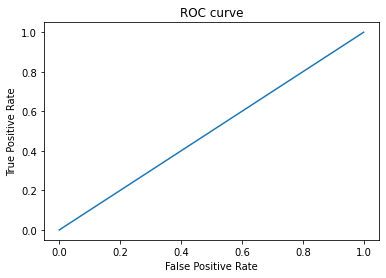

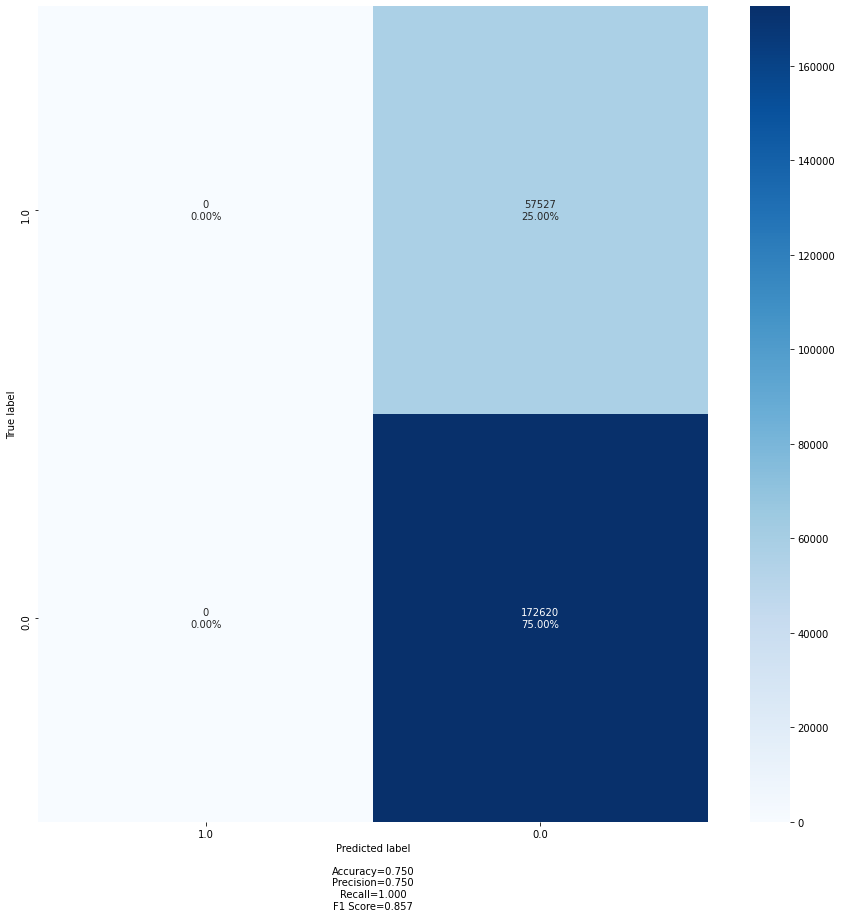

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent") 
dummy_clf.fit(treino_x, treino_y)
 
previsoes_burras = dummy_clf.predict(teste_x)
 
acuracia = accuracy_score(teste_y, previsoes_burras) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_x,dummy_clf)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, previsoes_burras,labels), figsize=(15,15), categories=labels)

## Decision Tree Classifier

A acurácia foi 82.01%
0.7995695763091497


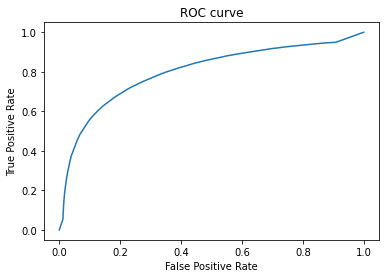

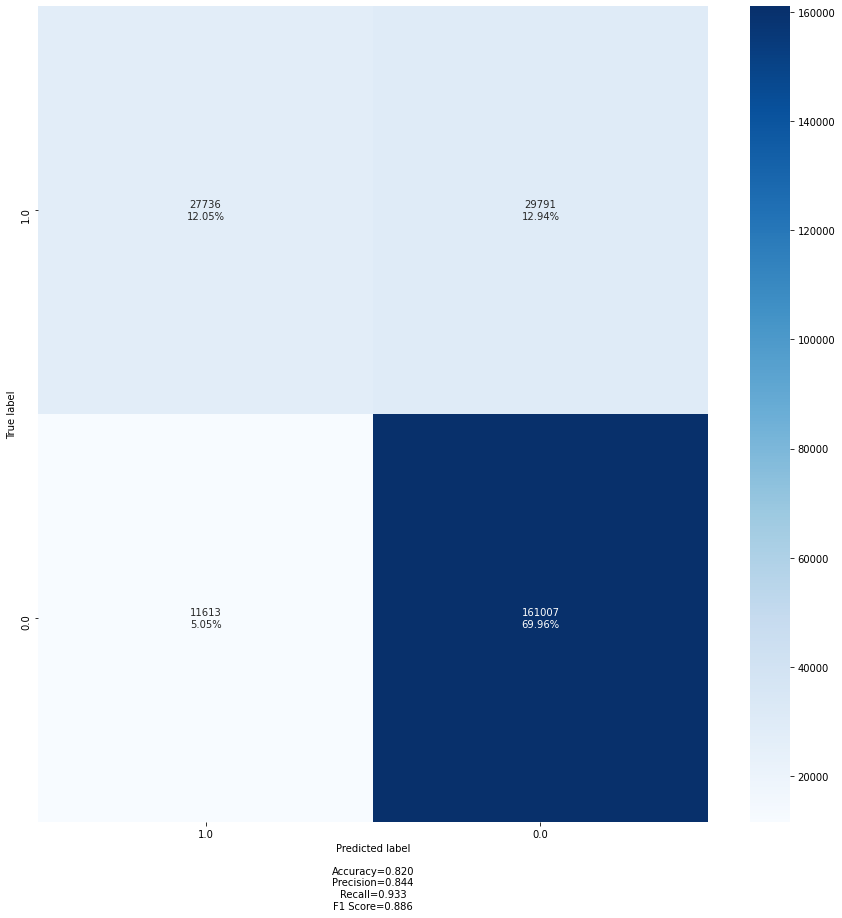

In [ ]:
modelo = DecisionTreeClassifier()
modelo = modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_x,modelo)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, previsoes,labels), figsize=(15,15), categories=labels)





A acurácia foi 82.63%
0.8294726946278823


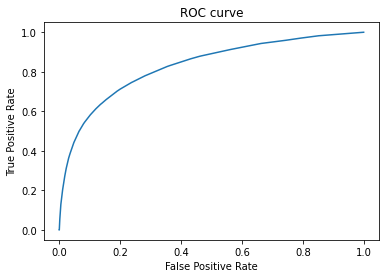

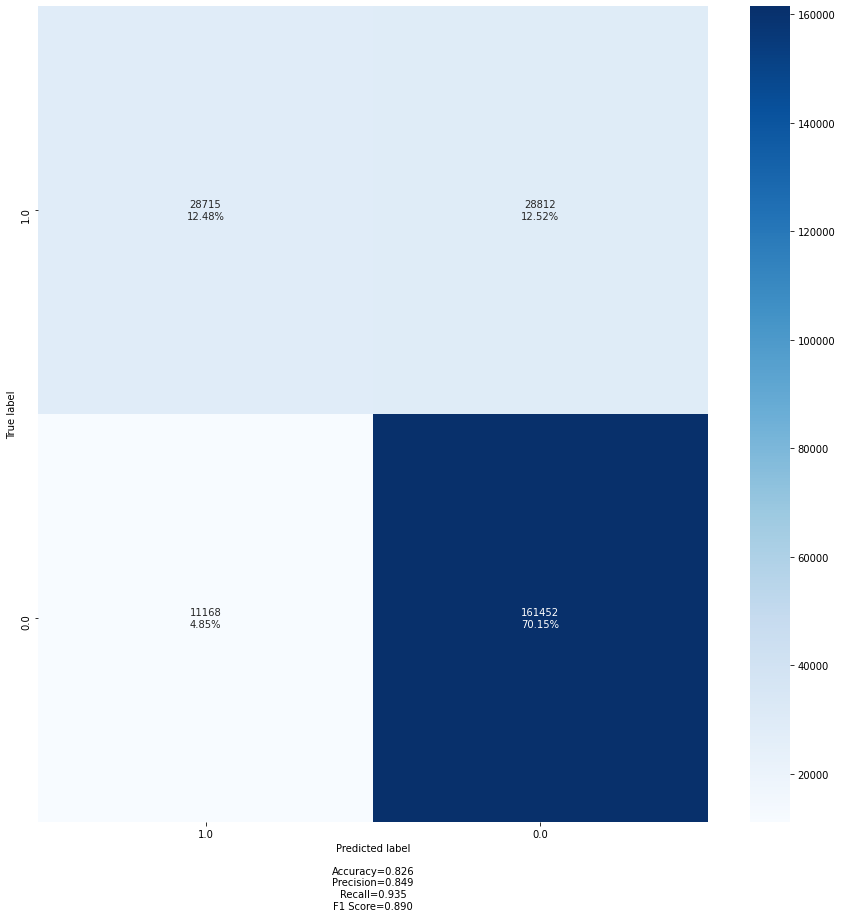

In [ ]:
modelo = DecisionTreeClassifier(max_depth=8)
modelo = modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)
 
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_x,modelo)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, previsoes,labels), figsize=(15,15), categories=labels)

In [ ]:
features = x.columns.tolist()
r = export_text(modelo, feature_names=features)
print(r)



|--- TP_DEPENDENCIA_ADM_ESC_Estadual <= 0.50
|   |--- TP_LINGUA_Espanhol <= 0.50
|   |   |--- ClasseSocial_E <= 0.50
|   |   |   |--- Estudo Pai_Superior <= 0.50
|   |   |   |   |--- TP_DEPENDENCIA_ADM_ESC_Municipal <= 0.50
|   |   |   |   |   |--- SG_UF_ESC_MG <= 0.50
|   |   |   |   |   |   |--- ClasseSocial_D <= 0.50
|   |   |   |   |   |   |   |--- Estudo Mãe_Superior <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- Estudo Mãe_Superior >  0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- ClasseSocial_D >  0.50
|   |   |   |   |   |   |   |--- TP_DEPENDENCIA_ADM_ESC_Particular <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- TP_DEPENDENCIA_ADM_ESC_Particular >  0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- SG_UF_ESC_MG >  0.50
|   |   |   |   |   |   |--- ClasseSocial_D <= 0.50
|   |   |   |   |   |   |   |--- Estudo Mãe_NaoSabe <= 0.50
|   

In [ ]:
print(confusion_matrix(teste_y, previsoes))
print(classification_report(teste_y, previsoes))

[[161452  11168]
 [ 28812  28715]]
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89    172620
         1.0       0.72      0.50      0.59     57527

    accuracy                           0.83    230147
   macro avg       0.78      0.72      0.74    230147
weighted avg       0.82      0.83      0.81    230147



In [ ]:
x

,TP_DEPENDENCIA_ADM_ESC_Estadual,TP_DEPENDENCIA_ADM_ESC_Federal,TP_DEPENDENCIA_ADM_ESC_Municipal,TP_DEPENDENCIA_ADM_ESC_Particular,TP_LINGUA_Espanhol,TP_LINGUA_Inglês,Estudo Pai_FundamentalCompleto,Estudo Pai_FundamentalIncompleto,Estudo Pai_Medio,Estudo Pai_NaoSabe,Estudo Pai_Superior,Estudo Mãe_FundamentalCompleto,Estudo Mãe_FundamentalIncompleto,Estudo Mãe_Medio,Estudo Mãe_NaoSabe,Estudo Mãe_Superior,Tem Computador_Não,Tem Computador_Sim,ClasseSocial_A,ClasseSocial_B,ClasseSocial_C,ClasseSocial_D,ClasseSocial_E,SG_UF_ESC_AC,SG_UF_ESC_AL,SG_UF_ESC_AM,SG_UF_ESC_AP,SG_UF_ESC_BA,SG_UF_ESC_CE,SG_UF_ESC_DF,SG_UF_ESC_ES,SG_UF_ESC_GO,SG_UF_ESC_MA,SG_UF_ESC_MG,SG_UF_ESC_MS,SG_UF_ESC_MT,SG_UF_ESC_PA,SG_UF_ESC_PB,SG_UF_ESC_PE,SG_UF_ESC_PI,SG_UF_ESC_PR,SG_UF_ESC_RJ,SG_UF_ESC_RN,SG_UF_ESC_RO,SG_UF_ESC_RR,SG_UF_ESC_RS,SG_UF_ESC_SC,SG_UF_ESC_SE,SG_UF_ESC_SP,SG_UF_ESC_TO,"PessoasPorQuarto_(0, 1]","PessoasPorQuarto_(1, 2]","PessoasPorQuarto_(2, 3]","PessoasPorQuarto_(3, 4]","PessoasPorQuarto_(4, 20]"
0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920583,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
920584,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
920585,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
920586,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


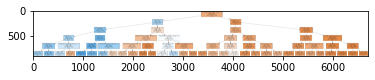

In [ ]:
dot_data = export_graphviz(modelo, out_file=None, 
                                feature_names=x.columns.tolist(),  
                   class_names=["0","1"],
                   filled=True)
 
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph
!pip install pydotplus
import pydotplus


graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')    
plt.imshow(plt.imread('tree.png'))

# Cross Valiadtion

In [ ]:

# modelo = modelo.fit(treino_x, treino_y)
# previsoes = modelo.predict(teste_x)
y




0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
920583    0.0
920584    0.0
920585    0.0
920586    0.0
920587    0.0
Name: classificacao, Length: 920588, dtype: float64

In [ ]:
from sklearn.model_selection import cross_validate
modelo = DecisionTreeClassifier(max_depth=8)
cross_validate(modelo, x, y, return_train_score=False,
               scoring=['accuracy',
                        'average_precision',
                        'f1',
                        'precision',
                        'recall',
                        'roc_auc'])

{'fit_time': array([4.6374476 , 4.58459759, 4.42486191, 4.51586962, 4.53593636]),
 'score_time': array([0.63922095, 0.63343692, 0.63153696, 0.64232755, 0.63375807]),
 'test_accuracy': array([0.81717703, 0.82170673, 0.829077  , 0.82917384, 0.82391088]),
 'test_average_precision': array([0.64000374, 0.66127603, 0.6739566 , 0.68279076, 0.66907126]),
 'test_f1': array([0.5064876 , 0.53936715, 0.57855689, 0.63776662, 0.63879945]),
 'test_precision': array([0.77858914, 0.76132942, 0.75393529, 0.67851104, 0.65547121]),
 'test_recall': array([0.3753205 , 0.4176137 , 0.46937268, 0.60163838, 0.62295474]),
 'test_roc_auc': array([0.79833098, 0.82476441, 0.82731351, 0.85137134, 0.85012997])}

# Categorical Naive Bayes

In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
modelo = clf.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

In [ ]:
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 78.49%


# KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(treino_x,treino_y)
predicoes = neigh.predict(teste_x)
#22 min execução

NameError: ignored

In [ ]:
print("Accuracy of model at K=4 is",accuracy_score(teste_y, predicoes))

Accuracy of model at K=4 is 0.8012922175826754


0.758012092937402


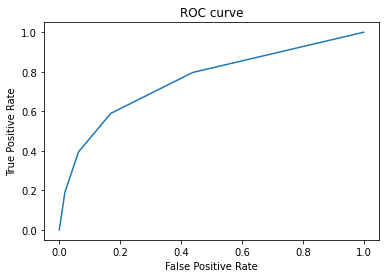

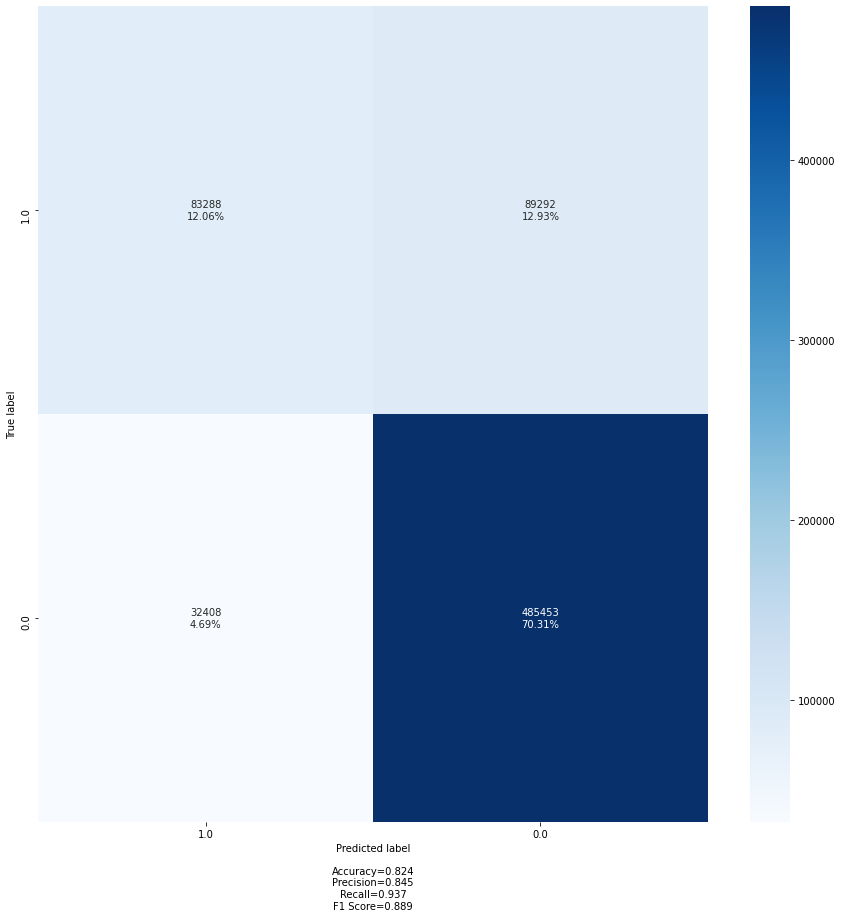

In [ ]:
calcRoc(teste_y,teste_x,neigh)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, predicoes,labels), figsize=(15,15), categories=labels)

# Substituindo Municipal por Estadual e Federal por Particular


In [ ]:
x = dados[['TP_SEXO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_LINGUA',
       'Estudo Pai', 'Estudo Mãe',
       'Tem Celular', 'Tem Computador',
       'Tem Internet', 'RendaMaxima',
       'COR_RACA', 'RazaoPessoasQuarto' 
    ]]

y = dados["classificacao"]

# y=y.astype('string')

In [ ]:
x.TP_DEPENDENCIA_ADM_ESC.replace(to_replace='Municipal',value="Estadual",inplace=True)
x.TP_DEPENDENCIA_ADM_ESC.replace(to_replace='Federal',value="Particular",inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
one_hot_data = pd.get_dummies(x)
x = one_hot_data


In [ ]:
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.75,
                                                         stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))


Treinaremos com 230147 elementos e testaremos com 690441 elementos


A acurácia foi 82.41%
0.8262710021516252


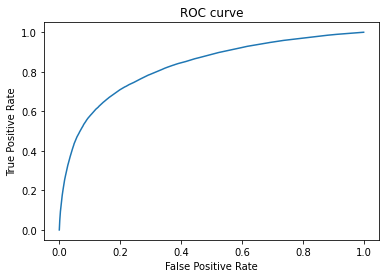

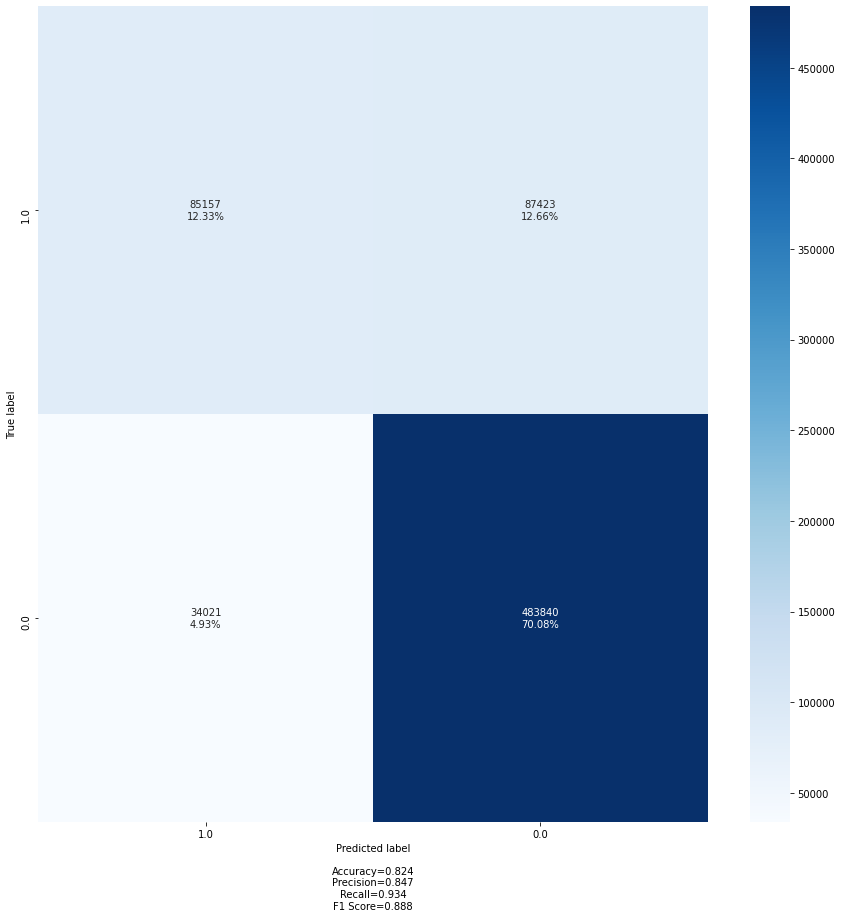

In [ ]:
modelo = DecisionTreeClassifier(max_depth=8)
modelo = modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_x,modelo)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, previsoes,labels), figsize=(15,15), categories=labels)


In [ ]:
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features)
grafico = graphviz.Source(dot_data)
grafico

NameError: ignored

#Decision Tree Regressor

In [ ]:
#TP_DEPENDENCIA_ADM_ESC

# x = publicas[["IDHM Educação 2010","TP_COR_RACA", "Q002", "Q024", "ClasseSocial"]]
y = dados["NU_MEDIA"]
# one_hot_data = pd.get_dummies(x)


In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.45)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

modelo_dummy = DummyRegressor()
modelo_dummy.fit(treino_x, treino_y)
dummy_predicoes = modelo_dummy.predict(teste_x)

mean_squared_error(teste_y, dummy_predicoes)

Treinaremos com 506323 elementos e testaremos com 414265 elementos


6512.226872915749

In [ ]:
modelo = DecisionTreeRegressor(max_depth=8)
modelo.fit(treino_x, treino_y)
predicoes_notas_lc = modelo.predict(teste_x)

print(mean_squared_error(teste_y, predicoes_notas_lc))

3939.136790344284


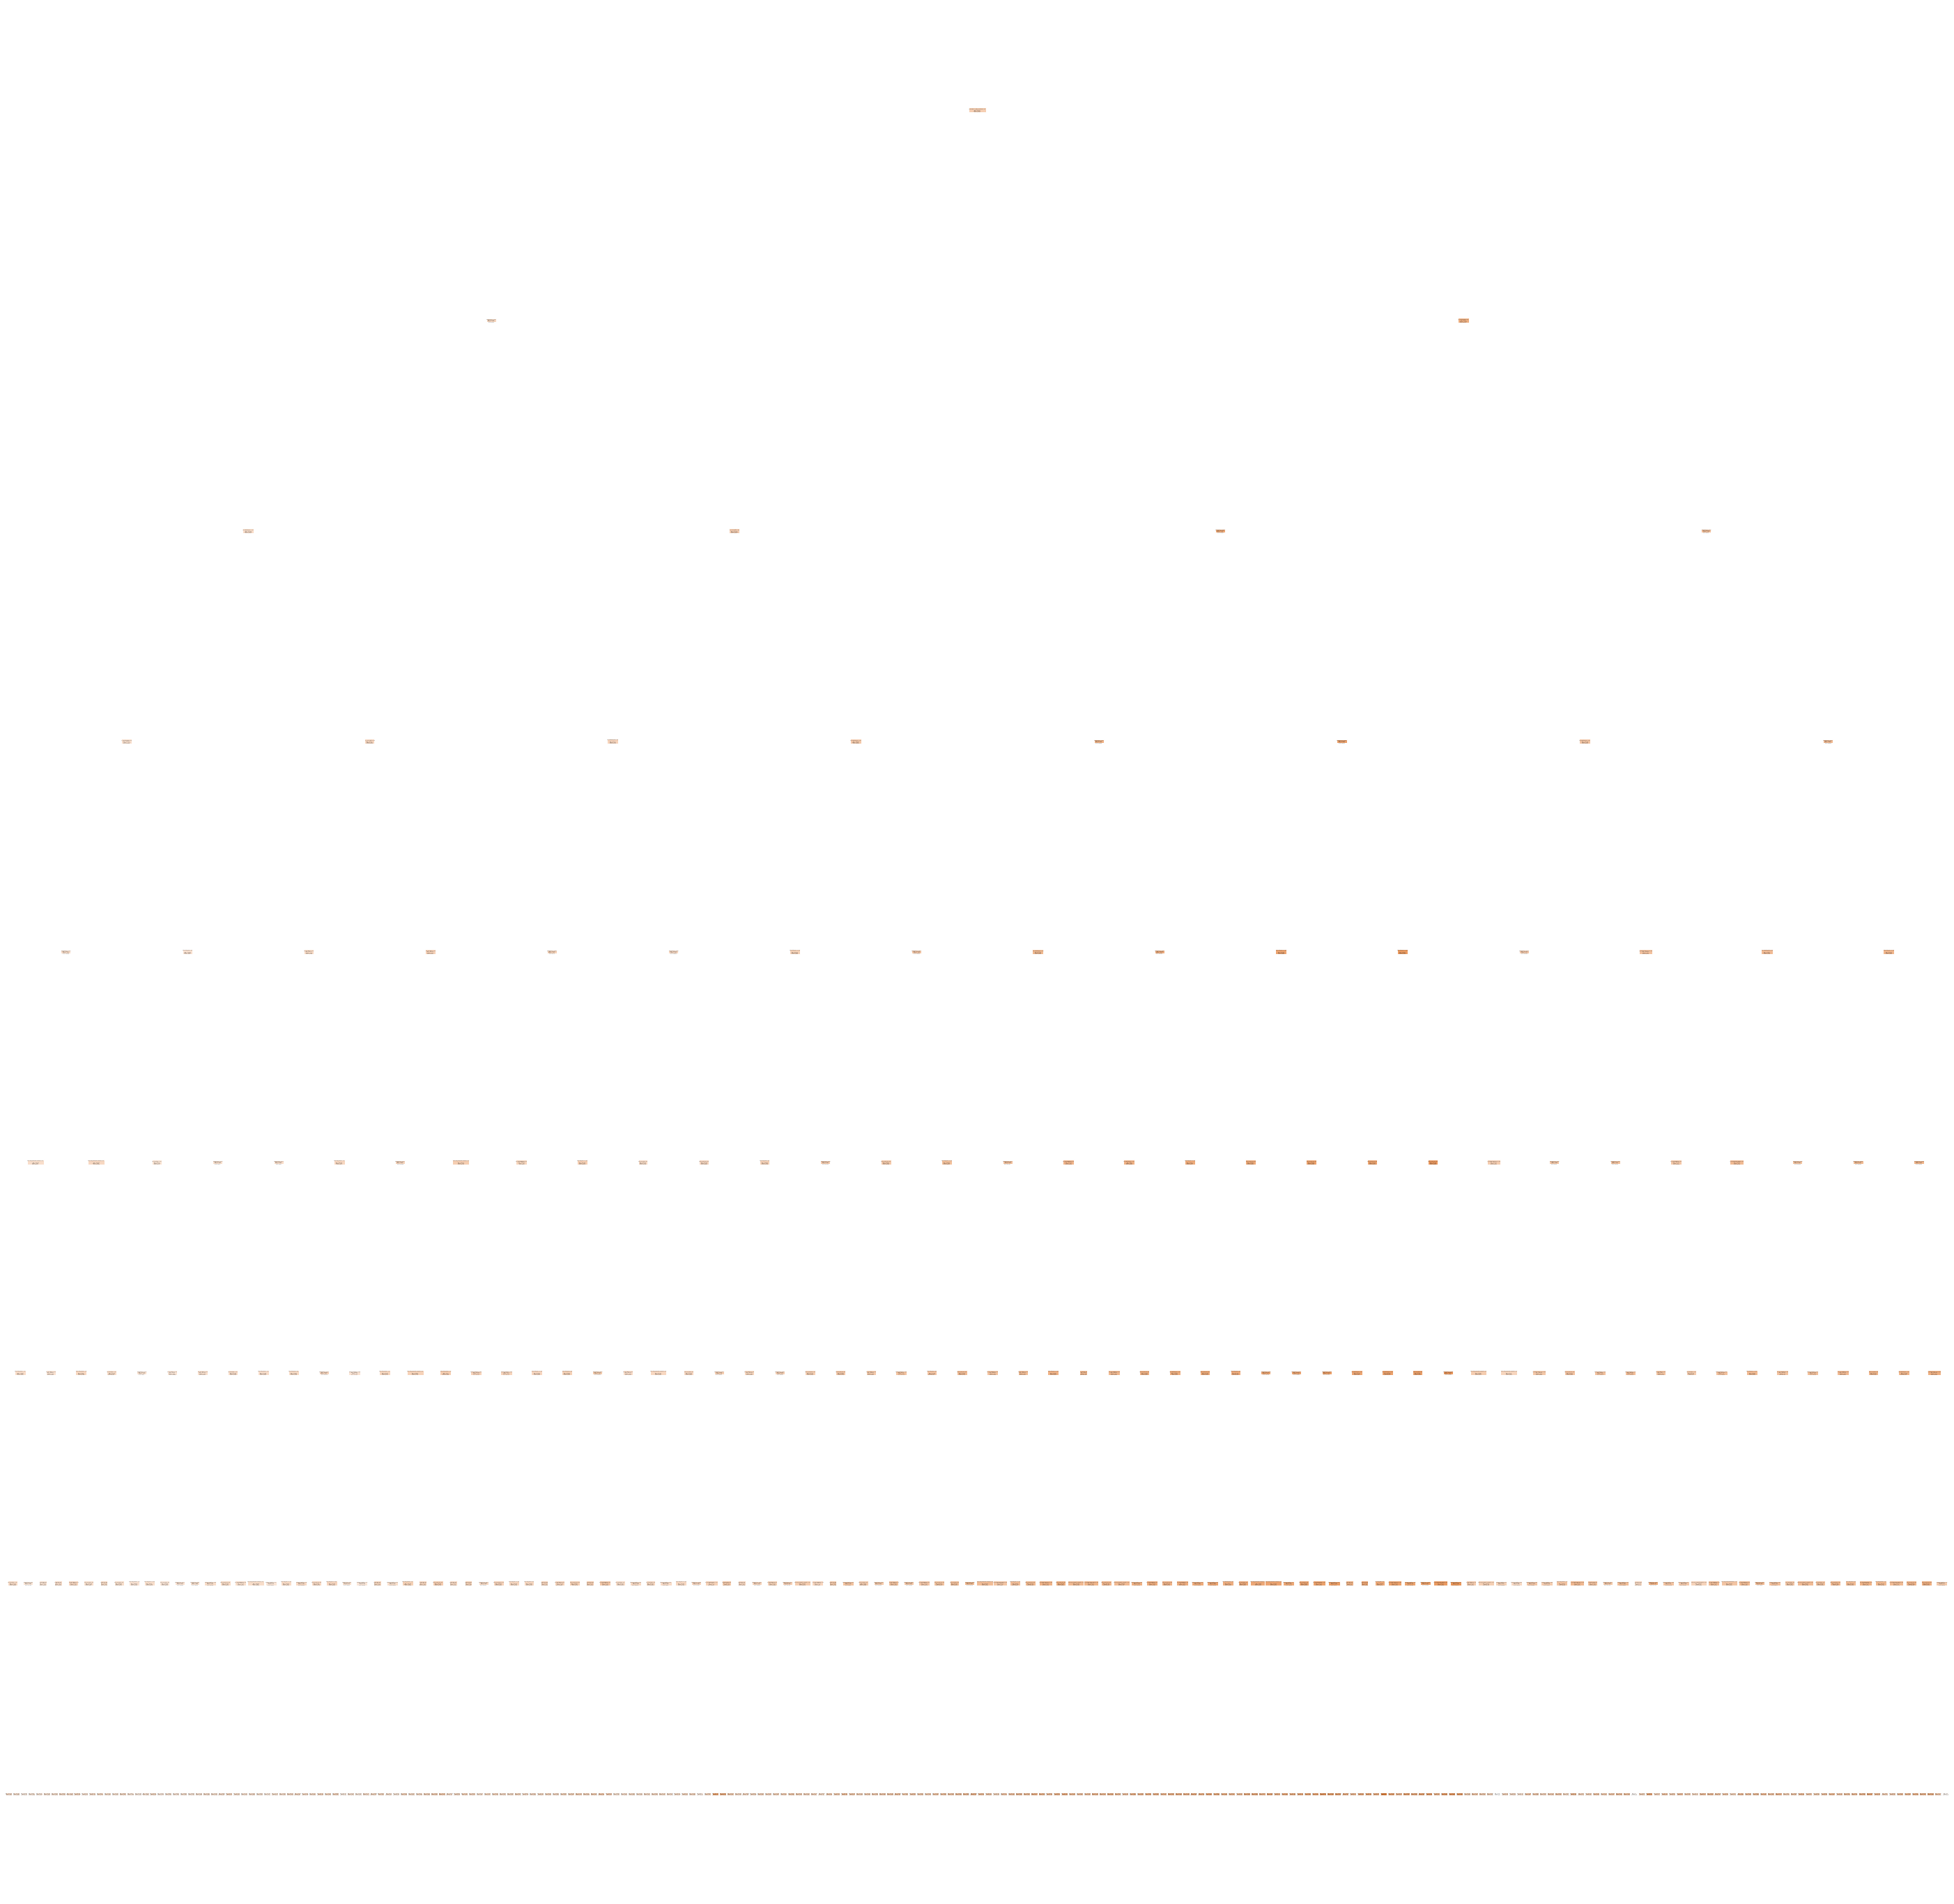

In [ ]:
from sklearn import tree
from matplotlib import figure


fig = figure.Figure(figsize=(250,200))
sns.set(rc={'figure.figsize':(50,50)})
x_names = x.columns.tolist()
y_names = "Media Nota"
_ = tree.plot_tree(modelo, 
                   feature_names=x_names,  
                   class_names=y_names,
                   filled=True)

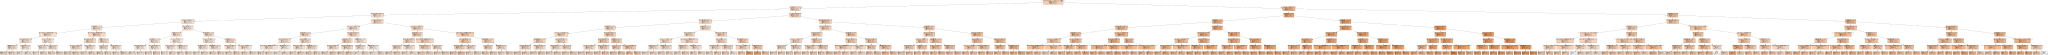

In [ ]:
dot_data = tree.export_graphviz(modelo, out_file=None, 
                                feature_names=x_names,  
                   class_names=y_names,
                   filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
# Algoritmos para lidar com unbalanced data:

#https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf

# Oversample

In [ ]:
x = dados[['TP_SEXO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_LINGUA',
       'Estudo Pai', 'Estudo Mãe',
       'Tem Celular', 'Tem Computador',
       'Tem Internet', 'RendaMaxima',
       'COR_RACA', 'RazaoPessoasQuarto' 
    ]]

y = dados["classificacao"]
one_hot_data = pd.get_dummies(x)
x = one_hot_data
x

,RendaMaxima,RazaoPessoasQuarto,TP_SEXO_F,TP_SEXO_M,TP_DEPENDENCIA_ADM_ESC_Estadual,TP_DEPENDENCIA_ADM_ESC_Federal,TP_DEPENDENCIA_ADM_ESC_Municipal,TP_DEPENDENCIA_ADM_ESC_Particular,TP_LOCALIZACAO_ESC_Rural,TP_LOCALIZACAO_ESC_Urbano,TP_LINGUA_Espanhol,TP_LINGUA_Inglês,Estudo Pai_FundamentalCompleto,Estudo Pai_FundamentalIncompleto,Estudo Pai_Medio,Estudo Pai_NaoSabe,Estudo Pai_Superior,Estudo Mãe_FundamentalCompleto,Estudo Mãe_FundamentalIncompleto,Estudo Mãe_Medio,Estudo Mãe_NaoSabe,Estudo Mãe_Superior,Tem Celular_Não,Tem Celular_Sim,Tem Computador_Não,Tem Computador_Sim,Tem Internet_Nao,Tem Internet_Sim,COR_RACA_Branco,COR_RACA_NaoBranco,COR_RACA_NaoDeclarado
0,1497,0.75,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0
1,998,4.00,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0
2,1497,1.50,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0
3,1497,3.00,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0
4,1497,1.50,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920583,998,2.50,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0
920584,7984,1.50,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0
920585,4990,1.67,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0
920586,7984,1.33,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0


In [ ]:
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.75,stratify = y)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 230147 elementos e testaremos com 690441 elementos


https://datascience.stackexchange.com/questions/15630/train-test-split-after-perform-smote#:~:text=2%20Answers&text=When%20use%20any%20sampling%20technique,only%20original%20samples)%20to%20evaluate.

## SMOTE



In [ ]:
!pip install imbalanced-learn
import imblearn
print(imblearn.__version__)

0.4.3


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
oversample_treino_x, oversample_treino_y = oversample.fit_resample(treino_x, treino_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
len(treino_x)
treino_x

,RendaMaxima,RazaoPessoasQuarto,TP_SEXO_F,TP_SEXO_M,TP_DEPENDENCIA_ADM_ESC_Estadual,TP_DEPENDENCIA_ADM_ESC_Federal,TP_DEPENDENCIA_ADM_ESC_Municipal,TP_DEPENDENCIA_ADM_ESC_Particular,TP_LOCALIZACAO_ESC_Rural,TP_LOCALIZACAO_ESC_Urbano,TP_LINGUA_Espanhol,TP_LINGUA_Inglês,Estudo Pai_FundamentalCompleto,Estudo Pai_FundamentalIncompleto,Estudo Pai_Medio,Estudo Pai_NaoSabe,Estudo Pai_Superior,Estudo Mãe_FundamentalCompleto,Estudo Mãe_FundamentalIncompleto,Estudo Mãe_Medio,Estudo Mãe_NaoSabe,Estudo Mãe_Superior,Tem Celular_Não,Tem Celular_Sim,Tem Computador_Não,Tem Computador_Sim,Tem Internet_Nao,Tem Internet_Sim,COR_RACA_Branco,COR_RACA_NaoBranco,COR_RACA_NaoDeclarado
772329,4990,2.00,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0
374984,998,2.00,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0
524492,1497,2.00,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0
547300,1497,1.33,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0
904955,1497,1.50,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590642,4990,2.50,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0
156611,2495,3.00,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0
515588,0,3.00,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1
518739,1996,5.00,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0


In [ ]:
len(oversample_treino_x)

345242

In [ ]:
oversample_treino_x

array([[4.99000000e+03, 2.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.98000000e+02, 2.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.49700000e+03, 2.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.49500000e+03, 1.56713170e+00, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.49700000e+03, 2.35504286e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.49700000e+04, 1.25000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## Criando um Baseline


In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent") #uniform
dummy_clf.fit(oversample_treino_x, oversample_treino_y)

previsoes_burras = dummy_clf.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes_burras) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 75.00%


In [ ]:
from sklearn.model_selection import cross_validate
oversample = SMOTE()
oversample_x, oversample_y = oversample.fit_resample(x, y)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


920588

In [ ]:
modelo = DecisionTreeClassifier(max_depth=8)
cross_validate(modelo, oversample_x, oversample_y, return_train_score=False,
               scoring=['accuracy',
                        'average_precision',
                        'f1',
                        'precision',
                        'recall',
                        'roc_auc'])

{'fit_time': array([7.71835661, 7.40526247, 7.4443469 , 7.34033418, 7.34089923]),
 'score_time': array([0.94099379, 0.85667133, 0.86052704, 0.85562801, 0.86439443]),
 'test_accuracy': array([0.74357786, 0.79699703, 0.77694583, 0.74397613, 0.73403647]),
 'test_average_precision': array([0.83177546, 0.87688662, 0.8592224 , 0.81835495, 0.80618405]),
 'test_f1': array([0.70698629, 0.79054877, 0.76276186, 0.736035  , 0.72888994]),
 'test_precision': array([0.82467062, 0.816487  , 0.81455619, 0.75959257, 0.74327264]),
 'test_recall': array([0.61869555, 0.76620781, 0.71716053, 0.71389468, 0.7150533 ]),
 'test_roc_auc': array([0.81690459, 0.86988945, 0.85392438, 0.81594327, 0.80385587])}

In [ ]:
media_roc_auc = (0.81690459 + 0.86988945 + 0.85392438 + 0.81594327 + 0.80385587)/5
print(media_roc_auc)

0.8321035120000001


In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform") #uniform
dummy_clf.fit(treino_x, treino_y)

previsoes_burras = dummy_clf.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes_burras) * 100
print("A acurácia foi %.2f%%" % acuracia)

## Decision Tree

In [ ]:
modelo = DecisionTreeClassifier(max_depth=8)
modelo = modelo.fit(oversample_treino_x, oversample_treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_x,modelo)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, previsoes,labels), figsize=(15,15), categories=labels)


In [ ]:
x

In [ ]:
features = x.columns.tolist()
r = export_text(modelo, feature_names=features)
print(r)



In [ ]:
from sklearn.tree import export_graphviz
import graphviz
import pylab
dot_data = export_graphviz(modelo, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features)
grafico = graphviz.Source(dot_data)
grafico


In [ ]:
# from sklearn import tree
# plt.figure(figsize=(50 ,50 ))  # customize according to the size of your tree
# _ = tree.plot_tree(modelo, feature_names = x.columns)
# plt.show()

In [ ]:
modelo = DecisionTreeClassifier(max_depth=7)
modelo = modelo.fit(oversample_treino_x, oversample_treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)
calcRoc(teste_y,teste_x,modelo)
labels= y.unique()
make_confusion_matrix(confusion_matrix(teste_y, previsoes,labels), figsize=(15,15), categories=labels)

# Random Forest

In [ ]:
x = dados[['TP_SEXO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_LINGUA',
       'Estudo Pai', 'Estudo Mãe',
       'Tem Celular', 'Tem Computador',
       'Tem Internet', 'RendaMaxima',
       'COR_RACA', 'RazaoPessoasQuarto' 
    ]]

y = dados["classificacao"]

one_hot_data = pd.get_dummies(x)
x = one_hot_data
# y=y.astype('string')



In [ ]:
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.45)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))


Treinaremos com 506323 elementos e testaremos com 414265 elementos


In [ ]:
from sklearn.ensemble import RandomForestClassifier

classificador = RandomForestClassifier(n_estimators = 100)
classificador.fit(treino_x, treino_y)
print(classificador.score(teste_x,teste_y))



0.8096846221621425


0.7923299145613757


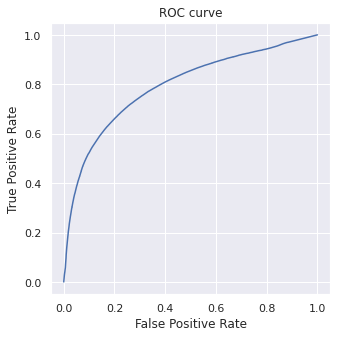

In [ ]:
plt.figure(figsize=(5,5 ))
calcRoc(teste_y,teste_x,classificador)


# SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


modelo = SVC(n_jobs=3)
clf = modelo.fit(treino_x, treino_y)


previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)
plt.figure(figsize=(5,5 ))
calcRoc(teste_y,teste_x,classificador)
make_confusion_matrix(confusion_matrix(teste_y, previsoes,labels), figsize=(15,15), categories=labels)

# Matrix de Confusão Exemplo

In [ ]:
y_true = ["gato", "formiga", "gato", "gato", "formiga", "gato"]
y_pred = ["formiga", "formiga", "gato", "gato", "formiga", "gato"]
confusion_matrix(y_true, y_pred, labels=["gato","formiga", "passaro"])
make_confusion_matrix(confusion_matrix(y_true, y_pred, labels=["gato","formiga"]), figsize=(15,15),categories= ["Gato", "Formiga"])

#y_true = ["gato", "formiga", "gato", "gato", "formiga", "passaro"]
#y_pred = ["formiga", "formiga", "gato", "gato", "formiga", "gato"]
#confusion_matrix(y_true, y_pred, labels=["gato","formiga", "passaro"])
#make_confusion_matrix(confusion_matrix(y_true, y_pred, labels=["gato","formiga", "passaro"]), figsize=(15,15))


# TP FP 
# FN TN 

In [ ]:
confusion_matrix(teste_y, previsoes,labels)
# make_confusion_matrix(confusion_matrix(teste_y, previsoes,labels), figsize=(15,15), categories = labels)

# Avaliando a solução: Precision, Recall, F1



### Recall: 
De todas as classes positivas, o quanto previmos corretamente. Deve ser o mais alto possível.

### Precision:
De todas as classes positivas que previmos corretamente, quantas são realmente positivas.

### Accuracy

De todas as classes, o quanto previmos corretamente. Deve ser o mais alto possível

### F-Score

É difícil comparar dois modelos com baixa precisão e alto recall ou vice-versa. Portanto, para torná-los comparáveis, usamos o F-Score. O F-Score ajuda a medir o recall e a precisão ao mesmo tempo

# ROC Curve

https://sites.icmc.usp.br/gbatista/files/ieee_la2008.pdf

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
def calcRoc(teste_y, teste_x, modelo):
  p = modelo.predict_proba(teste_x)[:,1]
  auc = roc_auc_score(teste_y,p)
  print(auc)
  fpr, tpr, _ = roc_curve(teste_y,p)

  plt.clf()
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.show()



# Script Matrix Confusão Bonitinha

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Clusterização

In [ ]:
col = dados.loc[: , "NU_NOTA_CN":"NU_NOTA_REDACAO"]
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X = scaler.fit_transform(col.values)

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.cluster import KMeans
import time
oldTime = time.time()

clusterer = KMeans(n_clusters=2,random_state=13,max_iter=300)
cluster_labels = clusterer.fit_predict(X)



labels = pd.DataFrame(clusterer.labels_)



elapsed = time.time() - oldTime;

print("Time: ", elapsed)



ValueError: ignored

## Silhueta

In [ ]:
oldTime = time.time()
silhouette_avg = silhouette_score(X, cluster_labels)
print(silhouette_avg)

elapsed = time.time() - oldTime;

print("Time: ", elapsed)